In [2]:
import numpy as np
from tools import *
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(14,10)})
%load_ext autoreload
%autoreload 2

In [10]:
def nan_argsort(a):
    temp = a.copy()
    temp[np.isnan(a)] = -np.inf
    return temp.argsort()


def do_siavash(XsereisTotal, N, shift=1, norm=1):

    X = scipy.linalg.hankel(XsereisTotal)[: N + shift, : -N - shift + 1]

    X0 = X[:-shift]
    Xp = X[shift:]
    X0Xp = X0 @ Xp.T / X0.shape[1]
    X0X0 = X0 @ X0.T / X0.shape[1]

    GEV_sol = scipy.linalg.eig(X0Xp, X0X0)
    evals = np.real_if_close(GEV_sol[0])
    evecs = np.real_if_close(GEV_sol[1])
    sort_ord = nan_argsort(np.real(evals))[::-1]
    sign = np.sign(np.real(evecs[-1, sort_ord[0]]))
    evec = []
    for i, el in enumerate(evecs[:, sort_ord[0]]):
        evec.append(np.real(sign * el))

    evec = np.array(evec)
    X = scipy.linalg.hankel(XsereisTotal)[:N,:-N+1]
    proj_series = evec @ X
    proj_series = proj_series / proj_series[0] * norm


    return proj_series, evec

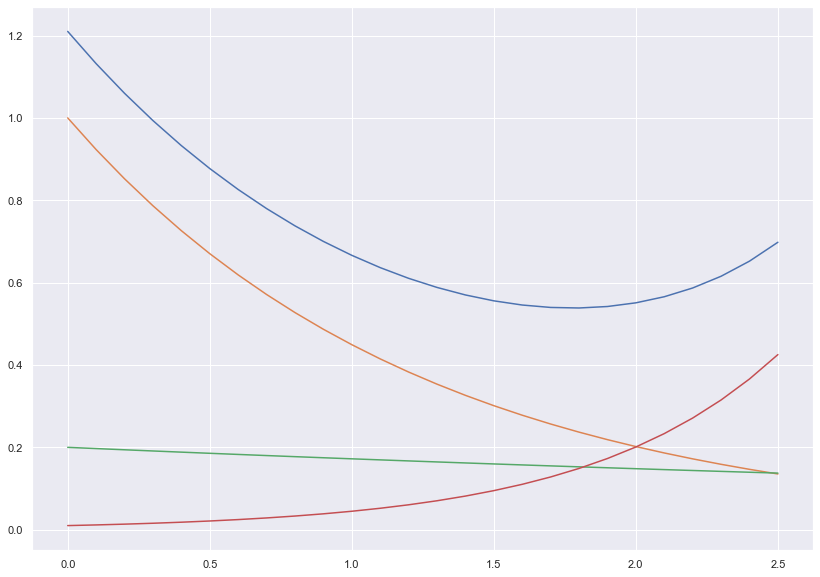

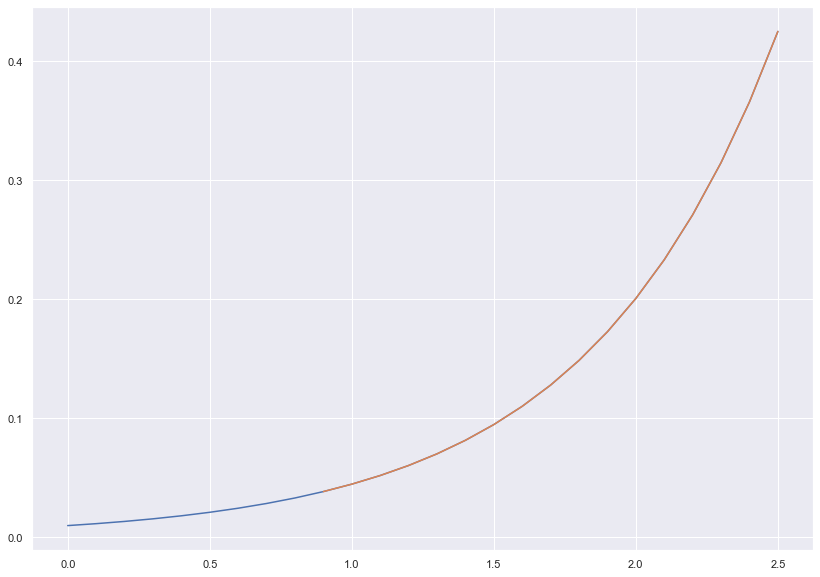

(26, 3) 0.4252108200006278


In [11]:
noise = 0.000001
N = 10


Exps = np.sort(np.array([1.5, -0.15, -0.8]))

N_max = 10
Ns = np.arange(3, N_max + 1, 3)
num_runs = 20
T = 2 * N_max
shifts = np.arange(1, 11, 3)
shift_max = max(shifts)

time = np.arange(0, 2.55, 0.1)
Inits = np.array([0.01, 0.2, 1])[::-1] * (1 + 0 * 0.1 * np.random.randn(3))
Xseries = np.exp(time.reshape(-1, 1) * Exps.reshape(1, -1)) * Inits.reshape(
    1, -1
)

XseriesNoisy = Xseries * (1 + noise * np.random.randn(*Xseries.shape))
XsereisTotal = XseriesNoisy.sum(1)

plt.plot(time, XsereisTotal);
plt.plot(time, Xseries);
plt.show()

proj_series, evec = do_siavash(XsereisTotal, N, shift=1, norm=Xseries[N - 1, -1])


X_target = XseriesNoisy[:, -1]
plt.plot(time, X_target)
plt.plot(time[len(time)-len(proj_series):], proj_series)
plt.show()


print(Xseries.shape, Xseries[- 1, -1])

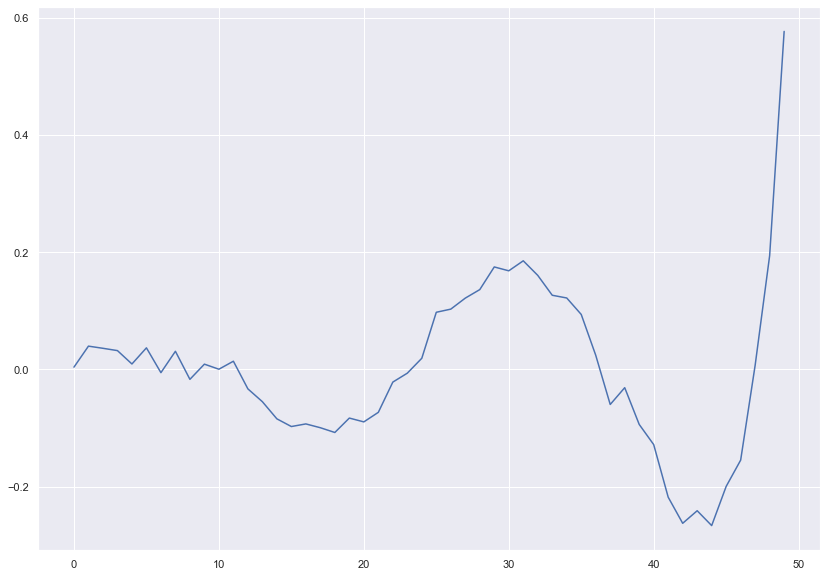

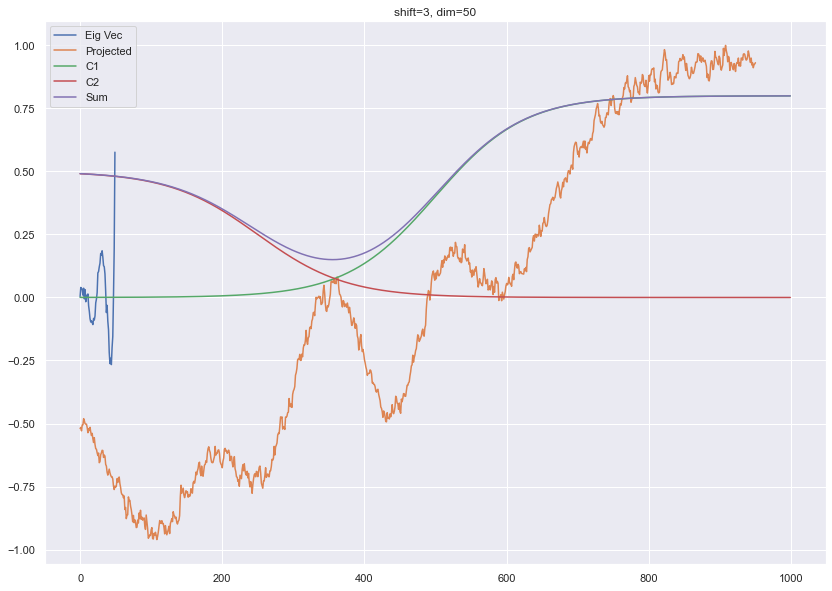

In [12]:
ITRS = 1
N = 1000
noise = 0.000001
dim = 50
shift = 10
L  = N-dim-shift
center = False

shifts = [3]
dims = np.linspace(50,500,1, dtype=int)

ys = []
for shift in shifts:
    for dim in dims:
        x = np.linspace(-8,8,N)
        sig1 = tanh(x, a=0.8, lam=1)
        sig2 =  tanh(x, a=0.5, lam=1, center=-4)[::-1]


        sig = sig1 +sig2 + noise * np.random.normal(size=N, scale=1)



        proj_series, evec = do_siavash(sig, dim, shift=shift, norm=sig2[-1])
    
        plt.plot(evec); plt.show()
        
        proj_series = normalize(proj_series)
        plt.plot(evec); plt.plot(proj_series); plt.plot(sig1); plt.plot(sig2); plt.plot(sig);
        plt.legend(['Eig Vec', 'Projected', 'C1', 'C2', 'Sum' ])
        plt.title(f'shift={shift}, dim={dim}')
        plt.show()


        y = np.convolve(sig, evec, mode='valid')
        ys.append(y)


In [94]:
def build_signal_grid(x, num, noise=0, return_basis=False, center=False):
    final_sig = np.zeros_like(x)
    basis = []
    for i in range(num):
        c = random.choice(x)
        sgn = rand_sgn()
        sig = tanh(x, a=1, lam=1, center=c)[::sgn]
        final_sig += sig
        if return_basis:
            basis.append(sig)
    final_sig += noise * np.random.normal(size=len(x), scale=1)

    if center:
        final_sig -= np.mean(final_sig)

    if return_basis:
        return final_sig, basis

    return final_sig


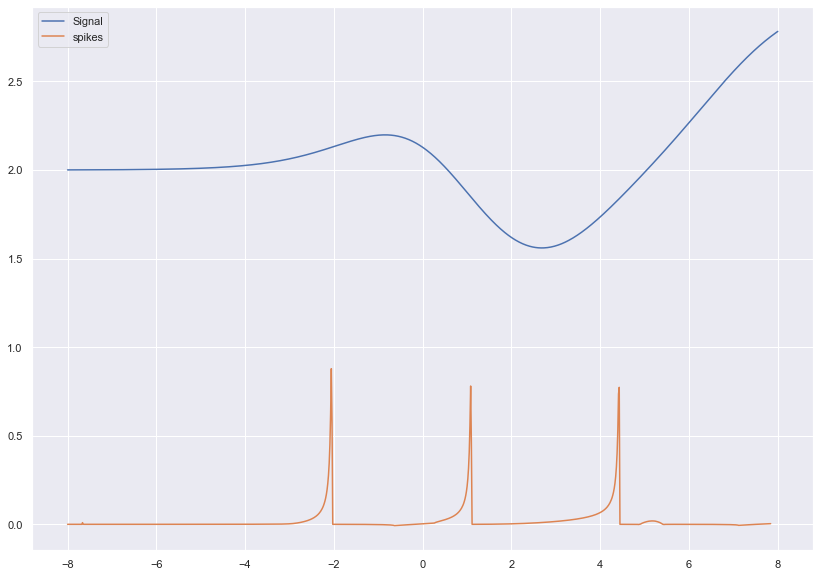

In [104]:

ITRS = 1
N = 1000
noise = 0.00001

x = np.linspace(-8,8,N)

num_components = 5
sig, basis = build_signal_grid(x, num_components, return_basis=True, center=True)

# time window shifted
window = 10
stride = 1
dim = 2
shift = 1
y = np.zeros(N-window)
for i in range(0, N-window, stride):


    sigwin = sig[i:i+window]
    proj_series, evec = do_siavash(sigwin, dim, shift=shift)

    y[i:i+stride] = evec @ sigwin[:dim]


plt.plot(x, sig, label='Signal');
# [plt.plot(x, c, label=f'C{i}') for i,c in enumerate(basis)]
plt.plot(x[:N-window], y, label='spikes');
# plt.plot(x[:N-window], normalize(y));
plt.legend()
plt.show()
